In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:

import tensorflow as tf
import keras 
from tensorflow.keras import backend as K


## Loss

In [5]:
''' calibrated categorical focal loss'''

def categorical_focal_loss_fixed(y_true, y_pred, alpha = 1.0, gamma = 2.0):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))  
    


## Importation

In [6]:
import shutil
import imutils
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [7]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix

In [9]:
# plt.imshow(cv2.imread(os.path.join('/content/gdrive/MyDrive/inbreast_images/test/normal',lis_images[0])));

## Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True
            )

valid_datagen = ImageDataGenerator()

In [11]:
TRAIN_LEN, VAL_LEN = 165,39

In [12]:
VAL_LEN

39

In [13]:
train_dir = '/content/gdrive/MyDrive/Inbrest-dataset/train'
valid_dir = '/content/gdrive/MyDrive/Inbrest-dataset/valid'
test_dir = '/content/gdrive/MyDrive/Inbrest-dataset/test'

In [14]:
TRAIN_BATCH_SIZE , VAL_BATCH_SIZE = 32, 16

In [15]:
train_generator = train_datagen.flow_from_directory(
                    directory = train_dir,
                    color_mode = 'rgb',
                    target_size = (224,224),
                    batch_size = 22,
                    class_mode = 'categorical'
                    )

valid_generator = valid_datagen.flow_from_directory(
                    directory = valid_dir,
                    color_mode = 'rgb',
                    target_size = (224,224),
                    batch_size = 22,
                    class_mode = 'categorical'
                    )

Found 173 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [16]:
test_datagen = ImageDataGenerator()
test_generator = valid_datagen.flow_from_directory(
                    directory = test_dir,
                    color_mode = 'rgb',
                    target_size = (224,224),
                    batch_size =22,
                    class_mode = 'categorical'
                    )

Found 18 images belonging to 2 classes.


In [17]:
#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

#check the class indices
print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}


In [18]:
from tensorflow.keras.utils import to_categorical
#true labels
Y_val=valid_generator.classes
print(Y_val.shape)

Y_test=test_generator.classes
print(Y_test.shape)

Y_test1=to_categorical(Y_test, num_classes=2, dtype='float32')
print(Y_test1.shape)

(23,)
(18,)
(18, 2)


In [19]:
#compute class weights to penalize over represented classes
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

print(class_weights)

{0: 1.005813953488372, 1: 0.9942528735632183}


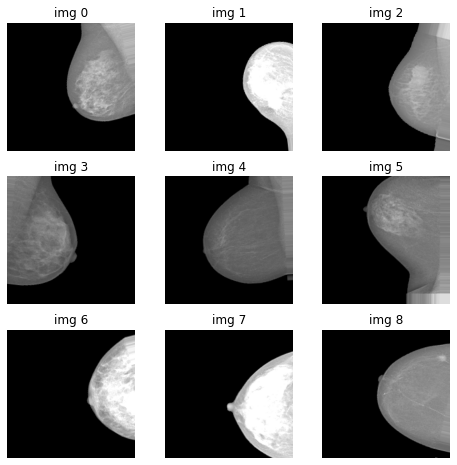

In [20]:
#plot a data aug
x = train_generator.next()[0].astype('uint8') #1 batch
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, axi in enumerate(axes.flat):
    axi.imshow(x[i])
    axi.set_title(f'img {i}')
    axi.set_axis_off();

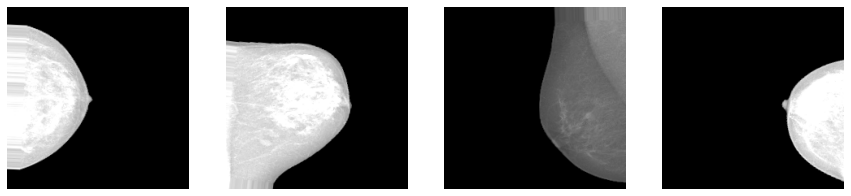

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = train_generator.next()[0].astype('uint8')

    # plot raw pixel data
    ax[i].imshow(image[i])
    ax[i].axis('off')

## The model

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras 
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import Flatten, Conv2D, Concatenate, MaxPooling2D, ZeroPadding2D, concatenate, Input, Reshape, GlobalAveragePooling2D, Dense, Dropout, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D

In [77]:
IMG_SHAPE = (224, 224, 3)
batch_size = 22
# Create the base model from the pre-trained VGG16
# base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE, # define the input shape
#                                                include_top=False, # remove the classification layer
#                                                pooling='avg',
#                                                weights='imagenet') # use ImageNet pre-trained weights
# base_model.trainable = True

# # adding regularization

from tensorflow.keras.applications import ResNet101
from tensorflow.keras import models, layers
model = ResNet101(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(224,224,3),
                pooling=None,
            )



regularizer = tf.keras.regularizers.l1(l1=1e-5)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

171458560/171446536 [==============================] - 3s 0us/step


In [71]:
# base_model = VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224,224,3)
# )

In [78]:
NUM_CLASSES = 2

from tensorflow.keras.models import Model,load_model
x = model.output 
x = ZeroPadding2D()(x)
x = Conv2D(32,(3,3), activation='relu', name = 'extra_conv_resnet') (x)
x = GlobalAveragePooling2D()(x) 
logits = Dense(2, 
              activation='softmax', 
              name='predictions')(x)

# model.layers[0].trainable = False 

model_resnet = Model(inputs=model.input, 
                    outputs=logits, 
                    name = 'resnet_pretrained')

model_resnet.summary()

Model: "resnet_pretrained"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [79]:
#%% train each model
from tensorflow.keras.optimizers import SGD, RMSprop,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
adam = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    amsgrad=True)
# dcakld_loss - dcahinge_loss - categorical_focal_loss_fixed 
# dcafocal_loss - entropy_loss - dcaentropy_loss - regularizer -categorical_focal_loss
# smoothcce02 - smoothfocal
model_resnet.compile(optimizers=sgd, 
                    loss= categorical_focal_loss_fixed, run_eagerly=True,  #use other losses in the same way
                    metrics=['accuracy']) 
#%%
#begin training
filepath = '/content/drive/MyDrive/weights/' + model_resnet.name + 'withoutweights_categorical_focal_loss_fixed.{epoch:02d}-{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              patience=40, 
                              verbose=1, 
                              mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=30,
                              verbose=1,
                              mode='max')
callbacks_list = [checkpoint,reduce_lr]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [80]:
#reset generators
train_generator.reset()
valid_generator.reset()

#train the model
model_history = model_resnet.fit(train_generator, 
                                      steps_per_epoch=nb_train_samples // batch_size,
                                      epochs=100, 
                                      validation_data=valid_generator,
                                      callbacks=callbacks_list, 
                                      class_weight = class_weights,
                                      validation_steps=nb_validation_samples // batch_size, 
                                      verbose=1)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.4834
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/weights/resnet_pretrainedwithoutweights_categorical_focal_loss_fixed.01-0.5000.h5
7/7 [==============================] - 36s 5s/step - loss: 0.3498 - accuracy: 0.4834 - val_loss: 0.3203 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.6026
Epoch 2: val_accuracy improved from 0.50000 to 0.54545, saving model to /content/drive/MyDrive/weights/resnet_pretrainedwithoutweights_categorical_focal_loss_fixed.02-0.5455.h5
7/7 [==============================] - 32s 5s/step - loss: 0.1883 - accuracy: 0.6026 - val_loss: 0.2338 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.5779
Epoch 3: val_accuracy did not improve from 0.54545
7/7 [==============================] - 

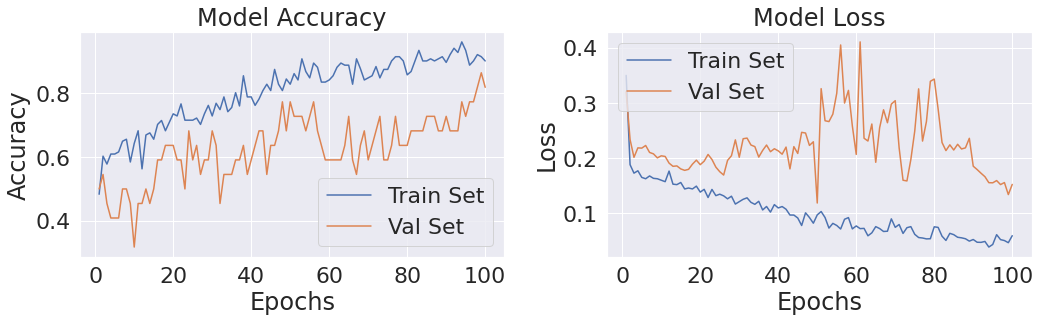

In [81]:
# plot model performance
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs_range = range(1, len(model_history.epoch) + 1)


plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [82]:
import pandas as pd
test_generator.reset() 
custom_y_pred = model_resnet.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
custom_y_pred1_label = custom_y_pred.argmax(axis=-1)

#%%
#save predictions to a CSV file

predicted_class_indices=np.argmax(custom_y_pred,axis=1)
print(predicted_class_indices)

'''
map the predicted labels with their unique ids such 
as filenames to find out what you predicted for which image.
'''

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#save the results to a CSV file
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predicted_class_indices,
                      "Labels":predictions})
# results.to_csv("performance/resnet_cce.csv",index=False)

1/1 [==============================] - 3s 3s/step
[0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0]


In [83]:
results

,Filename,Predictions,Labels
0,abnormal/20588536.png,0,abnormal
1,abnormal/22580341.png,0,abnormal
2,abnormal/22670278.png,0,abnormal
3,abnormal/22670465.png,0,abnormal
4,abnormal/22670855.png,1,normal
5,abnormal/24055502.png,1,normal
6,abnormal/24065761.png,0,abnormal
7,abnormal/53580858.png,0,abnormal
8,abnormal/53586960.png,1,normal
9,normal/22679036.png,1,normal


              precision    recall  f1-score   support

    abnormal     0.6667    0.6667    0.6667         9
      Normal     0.6667    0.6667    0.6667         9

    accuracy                         0.6667        18
   macro avg     0.6667    0.6667    0.6667        18
weighted avg     0.6667    0.6667    0.6667        18



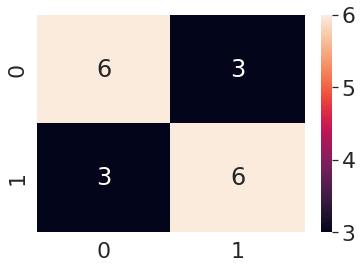

In [84]:
import seaborn as sns
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, accuracy_score 
from sklearn.utils import class_weight
target_names = ['abnormal','Normal']
print(classification_report(Y_test1.argmax(axis=-1),
                            custom_y_pred.argmax(axis=-1),
                            target_names=target_names, 
                            digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=5)

sns.set(font_scale=2)
b = sns.heatmap(cnf_matrix, annot=True)